<a href="https://colab.research.google.com/github/arturomf94/collage-art/blob/master/collage_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[How to run Object Detection and Segmentation on a Video Fast for Free](https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/)

## Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Install pycocotools

In [2]:
!pip install Cython

In [3]:
!ls

sample_data


In [4]:
!git clone https://github.com/waleedka/coco

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.40 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (540/540), done.


In [5]:
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

    100% |████████████████████████████████| 583kB 29.5MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 40.9.0
    Uninstalling setuptools-40.9.0:
      Successfully uninstalled setuptools-40.9.0


Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.33.1)
make: Entering directory '/content/coco/PythonAPI'
# install pycocotools to the Python site-packages
python setup.py build_ext install
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/inc

## Git Clone the code

In [6]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.70 MiB | 41.51 MiB/s, done.
Resolving deltas: 100% (555/555), done.


In [7]:
!ls

coco  Mask_RCNN  sample_data


## cd to the code directory and optionally download the weights file

In [8]:
import os
os.chdir('./Mask_RCNN')
!git checkout 555126ee899a144ceff09e90b5b2cf46c321200c
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Note: checking out '555126ee899a144ceff09e90b5b2cf46c321200c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 555126e Balloon Color Splash sample.
--2019-04-16 19:59:58--  https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/107595270/872d3234-d21f-11e7-9a51-7b4bc8075835?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=AKIAIWNJYAX4CS

In [0]:
# replace topology for saving in model.py to fix bug https://github.com/matterport/Mask_RCNN/pull/662/commits/bd780b5b13509ff057672ff41d936396e6128ccf
!sed -i 's/topology/saving/g' model.py

In [10]:
!ls

assets	    inspect_data.ipynb	   model.py	      train_shapes.ipynb
coco.py     inspect_model.ipynb    parallel_model.py  utils.py
config.py   inspect_weights.ipynb  README.md	      visualize.py
demo.ipynb  LICENSE		   samples
images	    mask_rcnn_coco.h5	   shapes.py


# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [11]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [12]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

## Create Model and Load Trained Weights

In [13]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [0]:
from google.colab import files
files.upload()

In [0]:
!ls

 016_16.JPG	       inspect_weights.ipynb	 samples
 assets		       LICENSE			 shapes.py
 coco.py	       mask_rcnn_coco.h5	 tikka1.JPG
 config.py	       model.py			 tikka2.jpg
 demo.ipynb	      'Negative0-18-18(1).jpg'	 train_shapes.ipynb
 images		       parallel_model.py	 utils.py
 inspect_data.ipynb    __pycache__		 visualize.py
 inspect_model.ipynb   README.md


## Run Object Detection

Processing 1 images
image                    shape: (1400, 2100, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 2100.00000


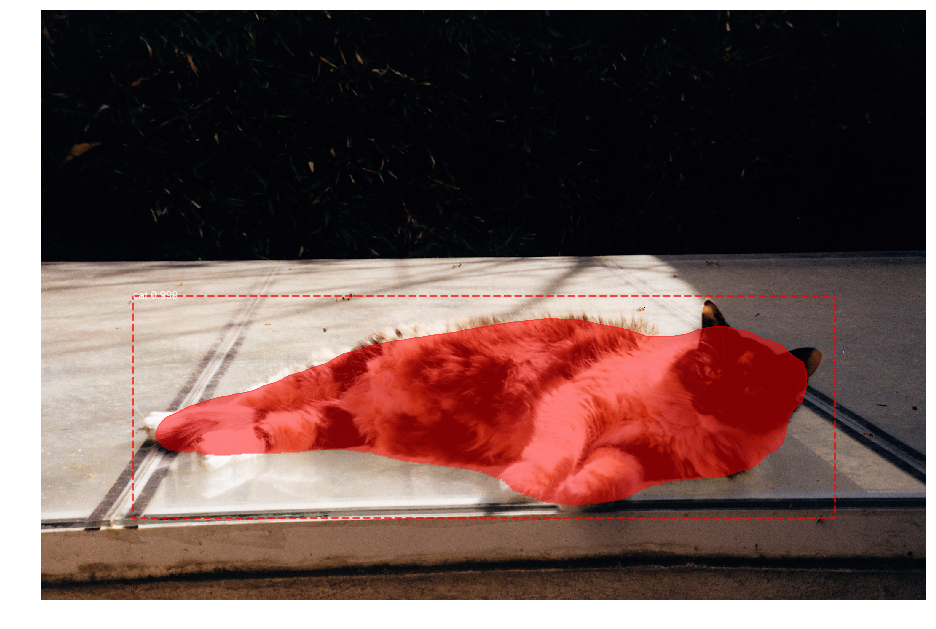

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('tikka2.jpg')
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

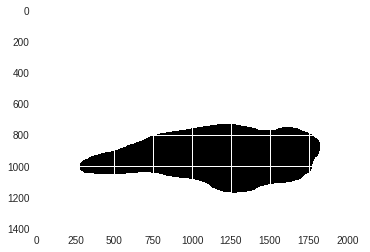

In [0]:
mask = r['masks'][:,:,0]
plt.imshow(mask)

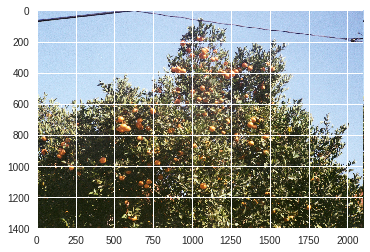

In [0]:
image_2 = skimage.io.imread('016_16.JPG')
plt.imshow(image_2)

In [0]:
print(image.shape)
print(image_2.shape)
# Resize if necessary
# image_2 = skimage.transform.resize(image_2, image.shape)

(1400, 2100, 3)
(1400, 2100, 3)


In [0]:
def image_crop(image_to_crop, mask, image_to_paste_on):
  new_image = np.copy(image_to_paste_on)
  ys, xs, zs = image_to_crop.shape
  for x in range(xs):
    for y in range(ys):
      if mask[y][x] == 1:
        new_image[y][x] = image_to_crop[y][x]
  return new_image
  

In [0]:
def inverse_image_crop(image_to_crop, mask, image_to_paste_on):
  new_image = np.copy(image_to_crop)
  ys, xs, zs = image_to_crop.shape
  for x in range(xs):
    for y in range(ys):
      if mask[y][x] == 1:
        new_image[y][x] = image_to_paste_on[y][x]
  return new_image

In [0]:
mask = r['masks'][:,:,0]
new_image = inverse_image_crop(image, mask, image_2)

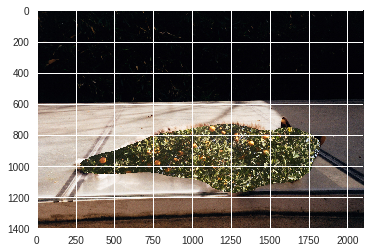

In [0]:
plt.imshow(new_image)

In [0]:
skimage.io.imsave('new_collage.jpg', new_image)

In [0]:
files.download('new_collage.jpg') 

## Process Video
Download the video mp4 file.

In [0]:
!mkdir videos

In [0]:
from google.colab import files
files.upload()

In [17]:
!ls

assets	    inspect_data.ipynb	   parallel_model.py   utils.py
coco.py     inspect_model.ipynb    __pycache__	       videos
config.py   inspect_weights.ipynb  README.md	       visualize.py
demo.ipynb  LICENSE		   samples
fred1.mp4   mask_rcnn_coco.h5	   shapes.py
images	    model.py		   train_shapes.ipynb


In [0]:
!mv fred1.mp4 ./videos

In [24]:
!ls ./videos

fred1.mp4  save


In [0]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    import coco
    import utils
    import model as modellib
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3

    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'fred1.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()

In [0]:
!ls ./videos/save

In [28]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'fred1.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976023976023978


In [29]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7f68c739e810>

In [30]:
!ls -alh ./videos/

total 49M
drwxr-xr-x 3 root root 4.0K Apr 16 20:30 .
drwxr-xr-x 8 root root 4.0K Apr 16 20:13 ..
-rw-r--r-- 1 root root 5.9M Apr 16 20:12 fred1.mp4
-rw-r--r-- 1 root root  43M Apr 16 20:30 out.mp4
drwxr-xr-x 2 root root  20K Apr 16 20:28 save


### Downlod the output video to our local machine

In [0]:
from google.colab import files
files.download('videos/out.mp4')

In [0]:
!ls

 016_16.JPG		 LICENSE		   shapes.py
 assets			 mask_rcnn_coco.h5	   tikka1.JPG
 coco.py		 model.py		   tikka2.jpg
 config.py		'Negative0-18-18(1).jpg'   train_shapes.ipynb
 demo.ipynb		 new_collage.jpg	   utils.py
 images			 parallel_model.py	   videos
 inspect_data.ipynb	 __pycache__		   visualize.py
 inspect_model.ipynb	 README.md
 inspect_weights.ipynb	 samples


# **Make video collage**

In [0]:
!mkdir video_collage

In [0]:
from google.colab import files
files.upload()

In [0]:
files.upload()

In [40]:
!ls

031_30.JPG  images		   model.py	      train_shapes.ipynb
assets	    inspect_data.ipynb	   parallel_model.py  utils.py
coco.py     inspect_model.ipynb    __pycache__	      video_collage
config.py   inspect_weights.ipynb  README.md	      videos
demo.ipynb  LICENSE		   samples	      visualize.py
fred1.mp4   mask_rcnn_coco.h5	   shapes.py


In [0]:
!mv fred1.mp4 ./video_collage

In [42]:
!ls ./video_collage

fred1.mp4


In [46]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors



def display_instances(image, image_2, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = inverse_image_crop(image, mask, image_2)
        # image = apply_mask(image, mask, color)
        # image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # image = cv2.putText(
        #     image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        # )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    import coco
    import utils
    import model as modellib
    
    # background image
    
    background = skimage.io.imread('031_30.JPG')
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3

    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "video_collage")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'fred1.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, background, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [47]:
!ls ./video_collage/save

0.jpg	 18.jpg   279.jpg  368.jpg  457.jpg  546.jpg  635.jpg  724.jpg	813.jpg
100.jpg  190.jpg  27.jpg   369.jpg  458.jpg  547.jpg  636.jpg  725.jpg	814.jpg
101.jpg  191.jpg  280.jpg  36.jpg   459.jpg  548.jpg  637.jpg  726.jpg	815.jpg
102.jpg  192.jpg  281.jpg  370.jpg  45.jpg   549.jpg  638.jpg  727.jpg	816.jpg
103.jpg  193.jpg  282.jpg  371.jpg  460.jpg  54.jpg   639.jpg  728.jpg	817.jpg
104.jpg  194.jpg  283.jpg  372.jpg  461.jpg  550.jpg  63.jpg   729.jpg	818.jpg
105.jpg  195.jpg  284.jpg  373.jpg  462.jpg  551.jpg  640.jpg  72.jpg	819.jpg
106.jpg  196.jpg  285.jpg  374.jpg  463.jpg  552.jpg  641.jpg  730.jpg	81.jpg
107.jpg  197.jpg  286.jpg  375.jpg  464.jpg  553.jpg  642.jpg  731.jpg	820.jpg
108.jpg  198.jpg  287.jpg  376.jpg  465.jpg  554.jpg  643.jpg  732.jpg	821.jpg
109.jpg  199.jpg  288.jpg  377.jpg  466.jpg  555.jpg  644.jpg  733.jpg	822.jpg
10.jpg	 19.jpg   289.jpg  378.jpg  467.jpg  556.jpg  645.jpg  734.jpg	823.jpg
110.jpg  1.jpg	  28.jpg   379.jpg  468.jpg  557.jpg  646.

In [48]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'fred1.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976023976023978


In [49]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "video_collage")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7f6761ae99f0>

In [50]:
!ls -alh ./video_collage/

total 44M
drwxr-xr-x 3 root root 4.0K Apr 17 00:13 .
drwxr-xr-x 9 root root 4.0K Apr 16 21:09 ..
-rw-r--r-- 1 root root 5.9M Apr 16 21:05 fred1.mp4
-rw-r--r-- 1 root root  38M Apr 17 00:13 out.mp4
drwxr-xr-x 2 root root  20K Apr 17 00:12 save


In [0]:
files.download('video_collage/out.mp4')

In [52]:
!ls

031_30.JPG  inspect_data.ipynb	   parallel_model.py   utils.py
assets	    inspect_model.ipynb    __pycache__	       video_collage
coco.py     inspect_weights.ipynb  README.md	       videos
config.py   LICENSE		   samples	       visualize.py
demo.ipynb  mask_rcnn_coco.h5	   shapes.py
images	    model.py		   train_shapes.ipynb
